<a href="https://colab.research.google.com/github/mohamedtal/PFE2021/blob/main/29_03_2021_exhaudateSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import random
import warnings
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization 
from keras.layers import Activation 
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset/EX_train.zip

In [ ]:
BATCH_SIZE = 32 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = 'EX_train/images/'
TEST_PATH = 'EX_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1

In [ ]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
#test_ids = next(os.walk(TEST_PATH))[2]
np.random.seed(10)

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.float32)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#######################################"" new version
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = load_img(path)
    img = img_to_array(img)
    img = resize(img, (512, 512, 3), mode = 'constant', preserve_range = True) 
    X_train[n] = img/255.0

    imageName = id_[:-4]

    path2 = 'EX_train/mask/'+ imageName +'_EX.png'
    mask = img_to_array(load_img(path2, grayscale=True))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)

    Y_train[n] = mask/255.0

# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

  0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 47/47 [00:21<00:00,  2.17it/s]


Text(0.5, 1.0, 'mask')

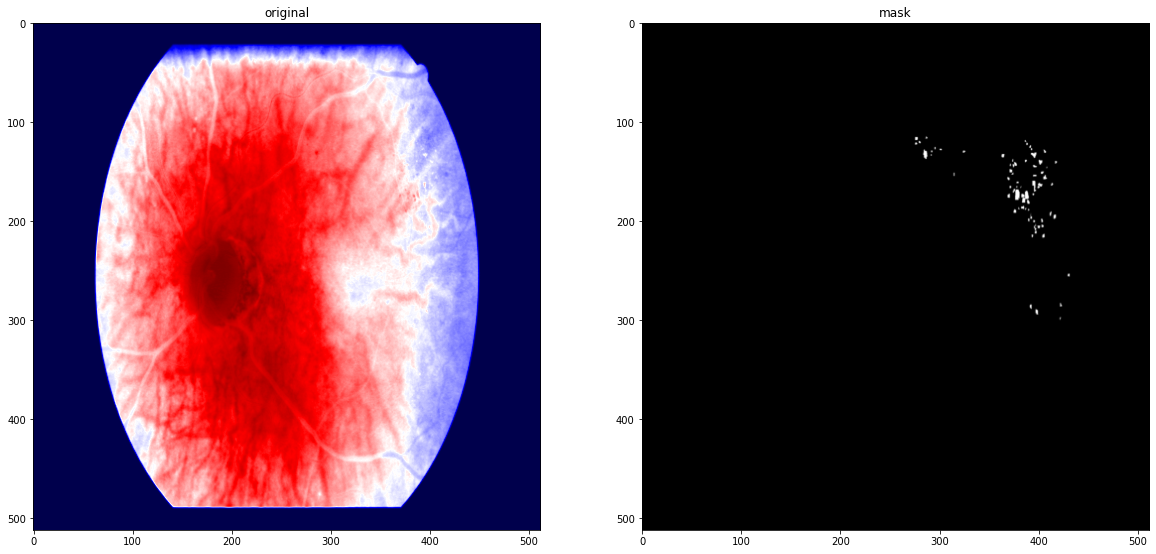

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
ax1.set_title('original')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('mask')

In [ ]:
# Data augmentation
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(
             rotation_range=90,
             width_shift_range=0.1,
             height_shift_range=0.1,
             zoom_range=0.2)
mask_datagen = image.ImageDataGenerator(
             rotation_range=90,
             width_shift_range=0.1,
             height_shift_range=0.1,
             zoom_range=0.2)

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE, seed=seed)
y=mask_datagen.flow(y_train,batch_size=BATCH_SIZE, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_valid, augment=True, seed=seed)
mask_datagen_val.fit(y_valid, augment=True, seed=seed)

x_val=image_datagen_val.flow(X_valid,batch_size=BATCH_SIZE, seed=seed)
y_val=mask_datagen_val.flow(y_valid,batch_size=BATCH_SIZE, seed=seed)

In [ ]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [ ]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
earlystopper = EarlyStopping(
            patience=10,
            verbose=1
)
model_checkpoint = ModelCheckpoint(
            'vesselSegmentation.h5',
            monitor='loss',
            verbose=1,
            save_best_only=True
)
input_img = Input((IMG_WIDTH, IMG_WIDTH, 3), name='img')
model = get_unet(input_img)
model.compile(optimizer=Adam(lr=1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit_generator(
            train_generator,
            epochs=50,
            steps_per_epoch=200,
            verbose=1,
            callbacks=[model_checkpoint, earlystopper],
            validation_data=val_generator,
            validation_steps=10
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
200/200 [==============================] - 301s 1s/step - loss: 0.4521 - accuracy: 0.8805 - val_loss: 0.2964 - val_accuracy: 0.9933

Epoch 00001: loss improved from inf to 0.35145, saving model to vesselSegmentation.h5
Epoch 2/50
200/200 [==============================] - 285s 1s/step - loss: 0.2150 - accuracy: 0.9892 - val_loss: 0.1714 - val_accuracy: 0.9933

Epoch 00002: loss improved from 0.35145 to 0.19963, saving model to vesselSegmentation.h5
Epoch 3/50
200/200 [==============================] - 284s 1s/step - loss: 0.1628 - accuracy: 0.9903 - val_loss: 0.1248 - val_accuracy: 0.9933

Epoch 00003: loss improved from 0.19963 to 0.15389, saving model to vesselSegmentation.h5
Epoch 4/50
200/200 [==============================] - 285s 1s/step - loss: 0.1304 - accuracy: 0.9907 - val_loss: 0.1022 - val_accuracy: 0.9933

Epoch 00004: loss improved from 0.15389 to 0.12469, saving model to vesselSegmentation.h5
Epoch 5/50
200/200 [==============================] - 285s 1s/step -

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# inference
#model.load_weights('vesselSegmentation.h5')

model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 281ms/step - loss: 0.0160 - accuracy: 0.9933


[0.016023728996515274, 0.9932960271835327]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 34ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

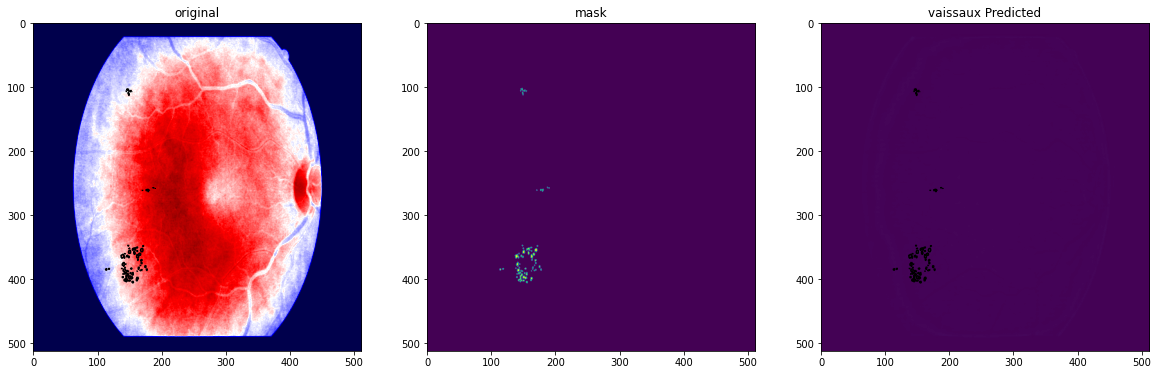

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('vaissaux Predicted')
    '''
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('vaissaux Predicted binary');
    '''

# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1)

In [ ]:
model.save('exhaudateSegmentation.h5')

Text(0.5, 1.0, 'tttttt')

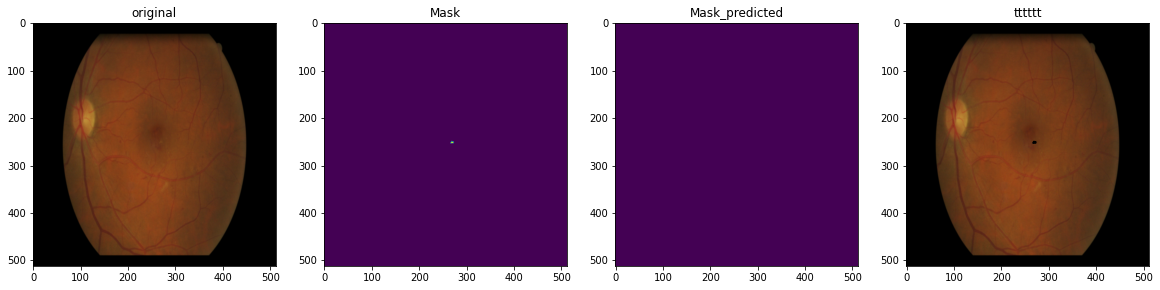

In [ ]:
ix = random.randint(0, len(preds_train_t))
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

has_mask = y_train[ix].max() > 0

ax[0].imshow(X_train[ix])
ax[0].set_title('original')


#plt.show()
ax[1].imshow(np.squeeze(y_train[ix]))
ax[1].set_title('Mask')

ax[2].imshow(np.squeeze(preds_train_t[ix]))
ax[2].set_title('Mask_predicted')

ax[3].imshow(X_train[ix])
if has_mask:
    ax[3].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[3].set_title('tttttt')
